# 1 Segment Dataset Architecture Comparisons on Finger Tips

In [1]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
tf.__version__

'2.0.0'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [4]:
df = pd.read_csv('jackson_index_1_joined.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [5]:
df.head()

,Leap timestamp,timestamp diff,emg timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
0,1.571862e+09,0.006472,1.571862e+09,56.0,152.0,318.0,58.0,30.0,26.0,37.0,168.0,27.481928,0.635315,44.404579,3.819370,-10.501190,57.583588,-39.021576,-14.662689,37.134148,-69.938087,-15.536011,26.992786,-90.684303,-16.765839,18.792263,-31.480103,3.195557,-11.996174,-48.617424,12.979187,-47.950493,-56.789734,2.440277,-66.780174,-59.230820,-12.140320,-73.670944,-12.269012,5.741394,-20.408253,-26.628906,19.429688,-61.925949,-36.830482,8.192657,-84.433563,-41.600212,-7.619537,-91.437363,9.305349,5.784424,-23.192884,-1.900085,17.207031,-62.730690,-11.677986,6.098206,-84.647568,-17.221012,-9.363892,-91.600197,29.291636,1.544373,-23.824600,22.835503,5.419800,-56.729340,17.429138,2.168213,-74.302849,11.652407,-4.481842,-88.201462
1,1.571862e+09,-0.017444,1.571862e+09,54.0,164.0,301.0,148.0,43.0,29.0,36.0,169.0,26.647976,-0.541893,44.900626,2.603665,-11.599823,57.431037,-39.666034,-14.301682,35.652349,-70.089661,-14.468178,24.132261,-90.578381,-15.055008,15.274604,-31.203072,3.832390,-12.509948,-47.597781,14.169205,-48.651957,-55.505336,3.798073,-67.685915,-57.910363,-10.747452,-74.662590,-11.808361,6.275238,-20.517360,-25.454881,20.207542,-62.191739,-35.418246,9.399536,-85.011818,-40.310819,-6.143776,-92.508541,9.811148,6.081985,-22.903098,-0.553401,17.576523,-62.645160,-9.981847,6.514847,-84.736057,-15.500547,-8.887718,-91.833954,29.747767,1.589165,-23.245819,24.140824,6.374512,-56.173798,19.047623,3.444153,-73.894844,13.431637,-3.077950,-87.919249
2,1.571862e+09,0.003166,1.571862e+09,50.0,161.0,401.0,184.0,49.0,32.0,37.0,162.0,25.490219,-3.977844,45.407623,0.888691,-15.207642,56.645126,-40.799980,-12.787781,33.687691,-70.586067,-9.926239,20.879833,-91.010010,-7.984314,12.033489,-30.784788,5.359344,-12.988110,-46.170105,17.185913,-49.120426,-53.684822,7.380035,-68.608513,-56.010406,-6.984161,-75.977188,-11.141672,7.823792,-20.362720,-23.704641,23.463989,-61.773483,-33.332466,13.942474,-85.301781,-38.390213,-0.982178,-93.875229,10.523100,7.254333,-22.239563,1.277081,20.302490,-61.781082,-7.774546,10.311188,-84.531990,-13.392775,-4.599304,-92.547852,30.355955,2.308136,-22.387161,26.408840,10.257629,-54.954762,21.679298,8.039429,-72.880737,16.065914,1.318481,-86.812164
3,1.571862e+09,0.010059,1.571862e+09,40.0,170.0,451.0,206.0,52.0,32.0,28.0,82.0,25.153648,-5.140533,45.478523,0.395868,-16.426270,56.309441,-41.075424,-11.990051,33.259583,-70.632256,-7.888000,20.259293,-91.043556,-4.950928,11.661678,-30.656673,5.864960,-13.072382,-45.760315,17.912903,-49.250374,-53.120193,8.142944,-68.815437,-55.381058,-6.207825,-76.230270,-10.946850,8.341492,-20.262655,-23.150558,24.345184,-61.641949,-32.622368,15.204285,-85.383560,-37.708450,0.511047,-94.331711,10.725384,7.651855,-22.008507,1.703369,20.909332,-61.532143,-7.254799,11.117615,-84.406494,-12.890709,-3.660126,-92.652481,30.522303,2.563080,-22.131792,27.211058,11.719635,-54.452309,22.549606,9.592224,-72.407104,16.854794,2.514252,-86.127

In [6]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)

In [7]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
count,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000,87843.000000
mean,50.264586,198.888585,393.293205,78.128844,30.925902,24.724622,32.397618,107.234304,3.930715,-11.523523,52.348950,-22.443899,-26.344469,49.591756,-54.614785,-20.539916,13.846868,-69.963748,-17.942858,-15.338769,-88.023557,-14.525735,-28.783127,-23.481550,6.347341,-25.090937,-19.997309,-3.830122,-55.333104,-17.379279,-12.529972,-65.847920,-15.510170,-18.606942,-70.826426,-2.284540,11.292973,-22.424998,6.078287,14.296624,-68.609535,10.934173,12.063061,-95.747102,14.051737,8.567686,-113.280935,18.734271,12.206061,-14.296344,29.419373,20.247313,-55.469134,35.846359,22.651409,-81.444783,40.047243,22.841092,-99.062572,37.854425,8.260404,-6.099804,57.697460,15.985495,-32.908477,68.449561,19.011425,-48.211941,77.724781,20.747419,-61.987531
std,16.065377,61.889771,123.922268,31.512907,8.177788,4.985910,13.017049,69.791079,5.672484,8.144951,2.259841,5.918031,7.949196,4.420398,4.894710,5.437073,7.636448,8.430987,9.291401,9.105312,10.886221,12.418942,11.302313,2.659676,4.404711,2.934735,6.755206,29.335207,10.244568,9.356353,44.427175,21.048910,11.165460,54.031633,31.470233,2.602536,3.520150,1.859236,8.639839,9.355284,2.668585,12.125271,14.331292,3.844615,14.346593,17.904034,5.031069,1.957883,2.718714,2.506316,7.988899,9.584357,3.777613,11.780185,14.753008,4.995936,14.318904,18.111585,6.020476,1.189455,3.285129,4.007710,5.691392,8.792838,6.452737,8.286797,12.380805,7.948119,10.596036,15.517381,9.297821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.546410,-39.911087,0.000000,-37.846565,-56.398163,0.000000,-64.980680,-42.962891,-10.776787,-85.509727,-55.793365,-44.110306,-106.816956,-65.868450,-65.092405,-33.983571,-17.390320,-32.209695,-57.944725,-51.231323,-72.944334,-66.356552,-74.435822,-96.285278,-75.462486,-91.046356,-112.788712,-18.186447,-9.201309,-25.658291,-43.688686,-47.724792,-73.316345,-41.276627,-75.498001,-101.111732,-47.323700,-93.674927,-119.497849,0.000000,-1.255035,-23.192884,-19.993179,-34.883713,-65.039101,-20.938644,-61.838303,-92.492859,-21.698006,-80.133446,

In [8]:
feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values

In [9]:
feature_ar.shape

(87843, 8)

In [10]:
label_ar.shape

(87843, 63)

From the above evaluation the initial untrained loss is around 2500.
Now train the model:

In [11]:
seq_length = 32

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
print(features.shape)
print(labels.shape)

(87812, 32, 8)
(87812, 63)


## Training the Model On Tips Only
In an attempt to improve the accuracy of prediction of the fingertips the above models are modified and trained only using the fingertip position data to understand if this simplification yields an improvement. This is done on both of the architectures tested above.

In [12]:
label_ar_t = label_ar[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
label_ar_t.shape

(87843, 18)

In [13]:
labels_tip = labels[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
labels_tip.shape

(87812, 18)

### Tips only with FC Architecture

In [14]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.5))
model_fc.add(Dense(18, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels_tip, batch_size=2048, epochs=8, verbose=1, validation_split=0.2)

Train on 70249 samples, validate on 17563 samples
Epoch 1/8
70249/70249 [==============================] - 33s 472us/sample - loss: 3093.2713 - val_loss: 2894.2592
Epoch 2/8
70249/70249 [==============================] - 25s 355us/sample - loss: 2336.5584 - val_loss: 1746.8642
Epoch 3/8
70249/70249 [==============================] - 25s 359us/sample - loss: 1251.9868 - val_loss: 785.9168
Epoch 4/8
70249/70249 [==============================] - 26s 363us/sample - loss: 909.9474 - val_loss: 486.4390
Epoch 5/8
70249/70249 [==============================] - 25s 362us/sample - loss: 589.8124 - val_loss: 402.1733
Epoch 6/8
70249/70249 [==============================] - 26s 367us/sample - loss: 660.9518 - val_loss: 549.6040
Epoch 7/8
70249/70249 [==============================] - 25s 356us/sample - loss: 529.4689 - val_loss: 454.9528
Epoch 8/8
70249/70249 [==============================] - 25s 362us/sample - loss: 496.5521 - val_loss: 454.7661


In [15]:
model_fc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 64)            18688     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               4

### Visual Model Error
A similar visualizion is now done on this new more restricted model. These errors show 20% - 25% improvement on fingertip y position.

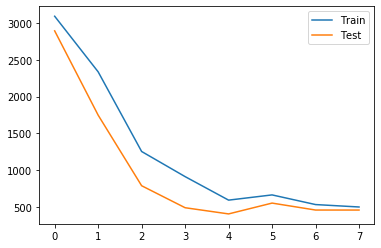

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

In [17]:
preds = model_fc.predict(features)

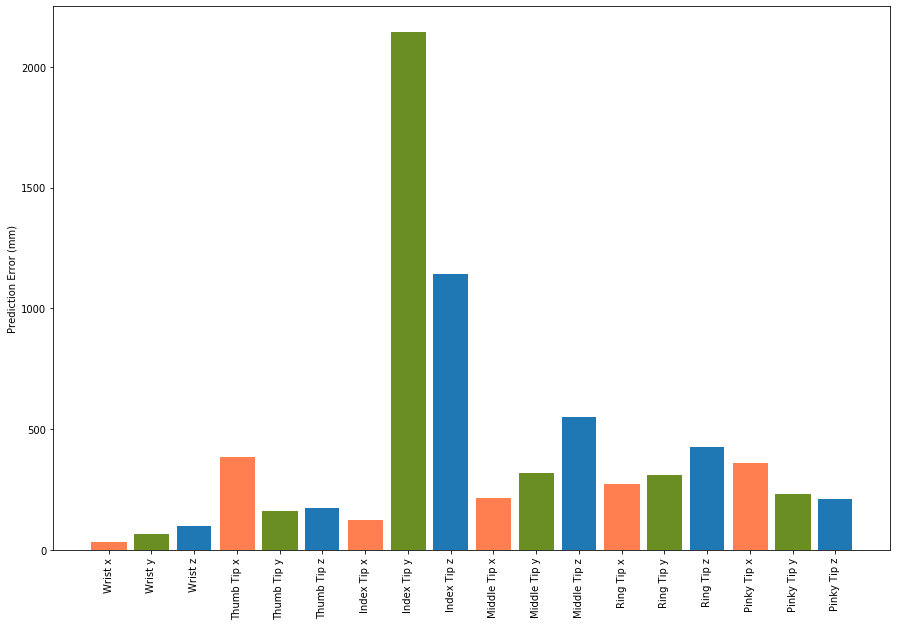

In [18]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## Large FC Model Architecture
Here a much larger model architecture is implemented to understand if this will improve results on the larger dataset. This dataset is approx 650MB, thus a larger model with proportionally higher parameters is expected to be required.

In [19]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(256, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(256, return_sequences=True))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(128))
model_fc.add(BatchNormalization())
model_fc.add(Dense(512, input_dim=128))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(512, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(256, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.3))
model_fc.add(Dense(18, input_dim=64))
    
model_fc.compile(optimizer='Adam', loss='mse')

In [20]:
model_fc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32, 256)           271360    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32, 256)           525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               197120    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

In [21]:
history = model_fc.fit(features, labels_tip, batch_size=512, epochs=8, verbose=1, validation_split=0.2)

Train on 70249 samples, validate on 17563 samples
Epoch 1/8
70249/70249 [==============================] - 210s 3ms/sample - loss: 971.7017 - val_loss: 4776.3685
Epoch 2/8
70249/70249 [==============================] - 201s 3ms/sample - loss: 353.1096 - val_loss: 323.1201
Epoch 3/8
70249/70249 [==============================] - 199s 3ms/sample - loss: 220.8060 - val_loss: 263.1873
Epoch 4/8
70249/70249 [==============================] - 202s 3ms/sample - loss: 187.6194 - val_loss: 419.5479
Epoch 5/8
70249/70249 [==============================] - 204s 3ms/sample - loss: 169.7060 - val_loss: 264.3906
Epoch 6/8
70249/70249 [==============================] - 202s 3ms/sample - loss: 165.9210 - val_loss: 321.1586
Epoch 7/8
70249/70249 [==============================] - 206s 3ms/sample - loss: 149.1318 - val_loss: 229.2482
Epoch 8/8
70249/70249 [==============================] - 210s 3ms/sample - loss: 170.9081 - val_loss: 298.8186


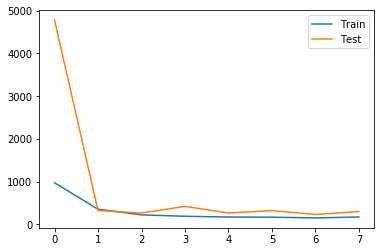

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

In [23]:
preds = model_fc.predict(features)

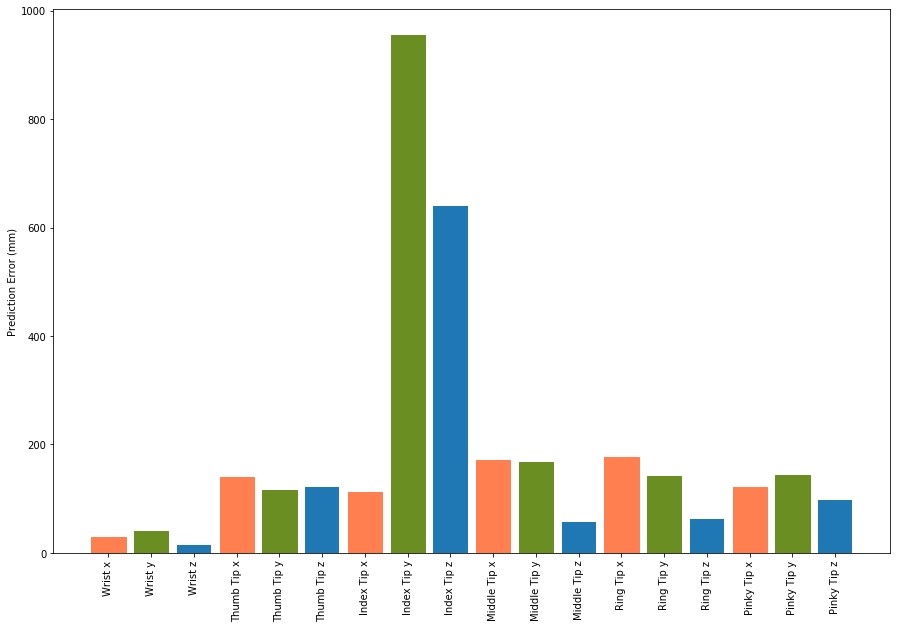

In [24]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()